# keras-nlp/example/machine_translation

- https://github.com/keras-team/keras-nlp/tree/master/examples/machine_translation

```
# Copyright 2023 The KerasNLP Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
```

In [25]:
# The hyperparameters, especially of the optimizer, seem picky.
# Currently, only the following versions go well only on mac with RMSprop.
#%pip install -U tensorflow==2.15.1 tensorflow-macos==2.15.1 keras==2.15.0
#%pip install keras-nlp

  Using cached tensorflow-2.15.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.4 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
Using cached tensorflow-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (205.7 MB)
Using cached tensorflow_macos-2.15.1-cp310-cp310-macosx_12_0_arm64.whl (2.2 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling 

In [1]:
# This version can not use keras.optimizers.legacy.RMSprop.
# And the model does not converge.
%pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1
#%pip install keras-nlp

  Using cached tensorflow-2.16.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached tensorflow_macos-2.16.2-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.2-cp310-cp310-macosx_12_0_arm64.whl (227.0 MB)
Using cached tensorflow_macos-2.16.2-cp310-cp310-macosx_12_0_arm64.whl (2.1 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling

In [1]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.16.2 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

# SageMaker cannot use @keras.saving
from keras import saving

Tensorflow 2.16.2 is expected. The running version is 2.16.2
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [2]:
import platform

def is_running_on_apple_sillicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )
    

In [4]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        # from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [5]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1)
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=tf.float32)
#     mask = tf.cast(y_true != 0, dtype=tf.float32)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Dataset

In [6]:
import pathlib
import random
import re
import string

def download_data():
    text_file = keras.utils.get_file(
        fname="spa-eng.zip",
        origin=(
            "http://storage.googleapis.com/download.tensorflow.org/data/"
            + "spa-eng.zip"
        ),
        extract=True,
    )
    return pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

def read_data(filepath):
    with open(filepath) as f:
        lines = f.read().split("\n")[:-1]
        text_pairs = []
        for line in lines:
            eng, spa = line.split("\t")
            spa = "[start] " + spa + " [end]"
            text_pairs.append((eng, spa))
    return text_pairs

def split_train_val_test(text_pairs):
    random.shuffle(text_pairs)
    num_val_samples = int(0.15 * len(text_pairs))
    num_train_samples = len(text_pairs) - 2 * num_val_samples
    train_pairs = text_pairs[:num_train_samples]
    val_end_index = num_train_samples + num_val_samples
    val_pairs = text_pairs[num_train_samples:val_end_index]
    test_pairs = text_pairs[val_end_index:]
    return train_pairs, val_pairs, test_pairs


strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


@saving.register_keras_serializable()
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase,
        "[%s]" % re.escape(strip_chars),
        "",
    )


def prepare_tokenizer(train_pairs, sequence_length, vocab_size):
    """Preapare English and Spanish tokenizer."""
    eng_tokenizer = keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=sequence_length,
    )
    spa_tokenizer = keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=sequence_length + 1,
        standardize=custom_standardization,
    )
    eng_texts, spa_texts = zip(*train_pairs)
    eng_tokenizer.adapt(eng_texts)
    spa_tokenizer.adapt(spa_texts)
    return eng_tokenizer, spa_tokenizer


def prepare_datasets(text_pairs, batch_size, eng_tokenizer, spa_tokenizer):
    """Transform raw text pairs to tf datasets."""
    eng_texts, spa_texts = zip(*text_pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)

    def format_dataset(eng, spa):
        """Format the dataset given input English and Spanish text.

        The output format is:
            x: a pair of English and Spanish sentence.
            y: The Spanish sentence in x shifts 1 token towards right, because
                we are predicting the next token.
        """
        eng = eng_tokenizer(eng)
        spa = spa_tokenizer(spa)
        return (
            {
                "encoder_inputs": eng,
                "decoder_inputs": spa[:, :-1],
            },
            spa[:, 1:],
            tf.cast((spa[:, 1:] != 0), "float32"),  # mask as sample weights
        )

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(tf.data.AUTOTUNE).cache()


def get_dataset_and_tokenizer(sequence_length, vocab_size, batch_size):
    """Main method to get the formatted machine translation dataset."""
    filepath = download_data()
    text_pairs = read_data(filepath)
    train_pairs, val_pairs, test_pairs = split_train_val_test(text_pairs)
    eng_tokenizer, spa_tokenizer = prepare_tokenizer(
        train_pairs, sequence_length, vocab_size
    )
    train_ds = prepare_datasets(
        train_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    val_ds = prepare_datasets(
        val_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    test_ds = prepare_datasets(
        test_pairs,
        batch_size,
        eng_tokenizer,
        spa_tokenizer,
    )
    return (train_ds, val_ds, test_ds), (eng_tokenizer, spa_tokenizer)

## Model

In [7]:
@saving.register_keras_serializable()
class TranslationModel(keras.Model):
    """The machine translation model.

    The model is an encoder-decoder structure model. The encoder is a stack of
    `keras_nlp.TransformerEncoder`, and the decoder is a stack of
    `keras_nlp.TransformerDecoder`. We also pass in the tokenizer for encoder
    and decoder so that during save/load, the tokenizer is also kept.
    """

    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        sequence_length,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoders = []
        self.decoders = []
        for _ in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )
        for _ in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    intermediate_dim=transformer_intermediate_dim,
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=True,
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            activation="softmax",
        )

    def call(self, inputs):
        encoder_input, decoder_input = (
            inputs["encoder_inputs"],
            inputs["decoder_inputs"],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            encoded = encoder(inputs=encoded)

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
            )

        output = self.dense(decoded)
        return output

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "sequence_length": self.encoder_embedding.sequence_length,
        })
        return config
    @classmethod
    def from_config(cls, config):
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(encoder_tokenizer=encoder_tokenizer, decoder_tokenizer=decoder_tokenizer, **config)

## Train

In [8]:
def run_training(
        model,
        train_ds,
        val_ds,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
    else:
        learning_rate = initial_learning_rate
    if f"{keras.__version__}".startswith("2.") and is_running_on_apple_sillicon():
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    if f"{keras.__version__}".startswith("2."):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=keras.losses.Reduction.NONE
        )
    else:
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            reduction=None
        )
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras_nlp.metrics.Bleu(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        steps_per_epoch=steps_per_epoch,
    )
    return history


In [9]:
def build_model(
        num_encoders,
        num_decoders,
        num_heads,
        transformer_intermediate_dim,
        sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        initial_learning_rate,
        decay_steps,
        decay_rate,
        epochs,
        steps_per_epoch):
    (
        (train_ds, val_ds, test_ds),
        (
            eng_tokenizer,
            spa_tokenizer,
        ),
    ) = get_dataset_and_tokenizer(
        sequence_length, vocab_size, batch_size
    )
    english_vocab_size = eng_tokenizer.vocabulary_size()
    spanish_vocab_size = spa_tokenizer.vocabulary_size()
    model = TranslationModel(
        encoder_tokenizer=eng_tokenizer,
        decoder_tokenizer=spa_tokenizer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        transformer_intermediate_dim=transformer_intermediate_dim,
        encoder_vocabulary_size=english_vocab_size,
        decoder_vocabulary_size=spanish_vocab_size,
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
    )

    history = run_training(
        model,
        train_ds,
        val_ds,
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
    )

    if is_running_on_apple_sillicon():
        filepath = 'machine_translation_model.keras/machine_translation_model.keras'
    else:
        filepath = 'machine_translation_model.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Decode and Predict

In [10]:
import numpy as np

EXAMPLES = [
    (
        "Tom doesn't listen to anyone.",
        "[start] Tomás no escucha a nadie. [end]",
    ),
    ("I got soaked to the skin.", "[start] Estoy chorreando. [end]"),
    ("I imagined that.", "[start] Me imaginé eso. [end]"),
    ("The baby is crying.", "[start] El bebé está llorando. [end]"),
    (
        "I've never felt so exhilarated.",
        "[start] Nunca me he sentido tan animado. [end]",
    ),
    (
        "Please forgive me for not having written sooner.",
        "[start] Perdóname por no haberte escrito antes, por favor. [end]",
    ),
    ("I expected more from you.", "[start] Esperaba más de vos. [end]"),
    ("I have a computer.", "[start] Tengo un computador. [end]"),
    ("Dinner's ready!", "[start] ¡La cena está lista! [end]"),
    ("Let me finish.", "[start] Déjame terminar. [end]"),
    ("I trust her.", "[start] Yo confío en ella. [end]"),
    ("I trust him.", "[start] Yo confío en él. [end]"),
]

def decode_sequence(input_sentence, model, max_sequence_length, lookup_table):
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = {
            "encoder_inputs": tokenized_input,
            "decoder_inputs": decoder_inputs,
        }
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(filepath, examples, sequence_length):
    loaded_model = keras.models.load_model(filepath)

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    translated = []
    for example in examples:
        translated.append(
            decode_sequence(
                example[0],
                loaded_model,
                sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ENGLISH SENTENCE: ", examples[i][0])
        print("MACHINE TRANSLATED RESULT: ", translated[i])
        print("GOLDEN: ", examples[i][1])


***

# Build

2024-07-02 18:07:49.248263: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-02 18:07:49.248294: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-07-02 18:07:49.248297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-07-02 18:07:49.248315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-02 18:07:49.248327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

1302/1302 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - loss: 4.7325 - masked_acc: 0.2549 - val_loss: 2.4468 - val_masked_acc: 0.5272
Epoch 2/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 103s 79ms/step - loss: 2.2540 - masked_acc: 0.5624 - val_loss: 1.8645 - val_masked_acc: 0.6169
Epoch 3/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 102s 78ms/step - loss: 1.5882 - masked_acc: 0.6560 - val_loss: 1.6786 - val_masked_acc: 0.6436
Epoch 4/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 102s 78ms/step - loss: 1.2438 - masked_acc: 0.7068 - val_loss: 1.6089 - val_masked_acc: 0.6545
Epoch 5/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 103s 79ms/step - loss: 1.0268 - masked_acc: 0.7435 - val_loss: 1.5863 - val_masked_acc: 0.6593
Epoch 6/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 105s 81ms/step - loss: 0.8780 - masked_acc: 0.7723 - val_loss: 1.5917 - val_masked_acc: 0.6618
Epoch 7/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 106s 81ms/step - loss: 0.7706 - masked_acc: 0.7954 - val_loss: 1.6178 - val_masked_acc: 0.6628
Epoch 8/20
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 107s 82ms/

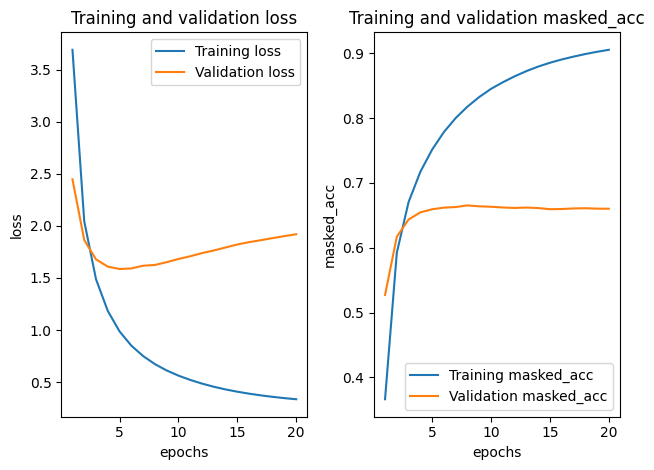

1.5862680673599243 The best number of epocs for the validation loss is 5
0.6652261018753052 The best number of epocs for the validation accuracy is 8


In [11]:
# minimum viable params
# Epoch 24/50 - loss: 0.1224 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.5755
FLAGS_learning_rate = 0.001
# It has been found out that the validation accuracy of this model turns to increasing within 20 epochs.
FLAGS_num_epochs = 20
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 100
FLAGS_decay_rate = 0.99

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [12]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefo

ENGLISH SENTENCE:  Tom doesn't listen to anyone.
MACHINE TRANSLATED RESULT:  [start] tom no escucha a nadie [end]
GOLDEN:  [start] Tomás no escucha a nadie. [end]
ENGLISH SENTENCE:  I got soaked to the skin.
MACHINE TRANSLATED RESULT:  [start] estoy [UNK] [end]
GOLDEN:  [start] Estoy chorreando. [end]
ENGLISH SENTENCE:  I imagined that.
MACHINE TRANSLATED RESULT:  [start] yo lo he [UNK] [end]
GOLDEN:  [start] Me imaginé eso. [end]
ENGLISH SENTENCE:  The baby is crying.
MACHINE TRANSLATED RESULT:  [start] el bebé está llorando [end]
GOLDEN:  [start] El bebé está llorando. [end]
ENGLISH SENTENCE:  I've never felt so exhilarated.
MACHINE TRANSLATED RESULT:  [start] nunca me he tenido tanto [UNK] [end]
GOLDEN:  [start] Nunca me he sentido tan animado. [end]
ENGLISH SENTENCE:  Please forgive me for not having written sooner.
MACHINE TRANSLATED RESULT:  [start] por favor perdóname por no haberte escrito [end]
GOLDEN:  [start] Perdóname por no haberte escrito antes, por favor. [end]
ENGLISH S

In [ ]:
# default params
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50 # default=1, but too small
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20 # Input and output sequence length.
FLAGS_vocab_size = 15000 # Vocabulary size, required by tokenizer.
FLAGS_batch_size = 64
FLAGS_num_encoders = 2
FLAGS_num_decoders = 2
FLAGS_num_heads = 8 # Number of head of the multihead attention.
FLAGS_intermediate_dim = 128 # Intermediate dimension (feedforward network) of transformer.
FLAGS_model_dim = 64
FLAGS_decay_steps = 20
FLAGS_decay_rate = 0.98

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

In [ ]:
# FLAGS_learning_rate = 0.001 # pegasus: 0.0005 > text generation: 2e-6
# minimum viable params
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 20
FLAGS_decay_rate = 0.98

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)

In [ ]:
# minimum viable params with no decay
# Epoch 24/50 - loss: 0.1224 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.8010 - val_sparse_categorical_accuracy: 0.5755
FLAGS_learning_rate = 0.001
FLAGS_num_epochs = 50
FLAGS_steps_per_epoch = None
FLAGS_sequence_length = 20
FLAGS_vocab_size = 15000
FLAGS_batch_size = 64
FLAGS_num_encoders = 1
FLAGS_num_decoders = 1
FLAGS_num_heads = 6
FLAGS_intermediate_dim = 512
FLAGS_model_dim = 64
FLAGS_decay_steps = 100
FLAGS_decay_rate = 1.0

model, filepath, history = build_model(
    num_encoders=FLAGS_num_encoders,
    num_decoders=FLAGS_num_decoders,
    num_heads=FLAGS_num_heads,
    transformer_intermediate_dim=FLAGS_intermediate_dim,
    sequence_length=FLAGS_sequence_length,
    vocab_size=FLAGS_vocab_size,
    batch_size=FLAGS_batch_size,
    embedding_dim=FLAGS_model_dim,
    initial_learning_rate=FLAGS_learning_rate,
    decay_steps=FLAGS_decay_steps,
    decay_rate=FLAGS_decay_rate,
    epochs=FLAGS_num_epochs,
    steps_per_epoch=FLAGS_steps_per_epoch,
)
plot(history=history)

In [ ]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    sequence_length=FLAGS_sequence_length,
)